# Dublin Buses - Clean Data

Prerequisites: `00-download-data.ipynb`

Before running the code in this notebook, you must download and concatenate all the original per-day data files into a single parquet file. Please use the above notebook to do this.

In [1]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
import osmnx as ox
from ipywidgets import interact, interact_manual
from tqdm import tqdm_notebook as tqdm
import folium
import multiprocessing
import collections
import matplotlib.pyplot as plt

from sklearn.neighbors import BallTree

from geo.geomath import vec_haversine, num_haversine
from geo.df import DataCleaner
from par.allel import parallel_process
from geo.df import mem_usage, categorize_columns

Read the data in parquet format, as generated by the first step. Note that not all columns are being read in.

In [2]:
columns_to_read = ['Timestamp', 'LineID', 'Direction', 'PatternID', 
                   'JourneyID', 'Congestion', 'Lon', 'Lat', 
                   'Delay', 'BlockID', 'VehicleID', 'StopID', 'AtStop']
df = pd.read_parquet("data/sir010113-310113.parquet", columns=columns_to_read)

Inspect the DataFrame memory consumption as read from storage.

In [5]:
mem_usage(df)

' 4997.05 MB'

As it stands, the `PatternID` column can be converted from string to categorical, saving us some precious memory.

In [6]:
df = categorize_columns(df, ['PatternID'])
mem_usage(df)

' 2586.19 MB'

Wow, that was an almost 50% reduction in memory consumption!

## Data Contents
Let us see what the DataFrame contains before any data cleaning.

In [7]:
df.shape[0]

44455133

In [8]:
journeys = df.JourneyID.unique()
journeys.shape[0]

18614

In [9]:
vehicles = df['VehicleID'].unique()
vehicles.shape[0]

911

In [10]:
stops = df['StopID'].unique()
stops.shape[0]

4728

## Data Quality
Here we will synthesize some of the missing features, such as the traveled distance and the average speed. This is done using a naïve approach. We start by calculating the time differences between consecutive observations. Next, we calculate the distance between these points, and finally we can infer the average speed.

Let's start off by sorting the DataFrame using the `VehicleID` and `Timestamp` as keys.

In [11]:
df = df.sort_values(by=['VehicleID', 'Timestamp'])

Next, we extract a series containing the sequence of vehicle identifiers. This will be useful to mark the rows that border consecutive vehicles.

In [12]:
vehicle_df = df['VehicleID']

We don't want to keep the distance between the last point of one vehicle, recorded at the end of the period, and the first point of the next vehicle, which will be recorded at the start of the next period. These values do not make any sense and will be later set to zero. This series will help us determine when to discard a consecutive calculation.

### Duration
Let's start by calculating the consecutive durations in seconds.

In [15]:
df['dt'] = df['Timestamp'].diff()
df['dt'] = df['dt'].fillna(value=0.0)
df['dt'] = df['dt'] / 1000000

### Distance
Now we can calculate the consecutive distances in meters.

In [16]:
lat0 = df['Lat'][:-1].to_numpy()
lon0 = df['Lon'][:-1].to_numpy()
lat1 = df['Lat'][1:].to_numpy()
lon1 = df['Lon'][1:].to_numpy()
dist = vec_haversine(lat0, lon0, lat1, lon1)
df['dx'] = np.insert(dist, 0, 0.0)

Now we must correct the consecutive durations and distances by setting to zero the ones at the beginning of each vehicle sequence. Please remember that these do not make sense as they are measuring durations and distances between different vehicles. The code to do this is simple enough:

In [18]:
df.loc[vehicle_df.diff() != 0, ['dt', 'dx']] = 0.0

The reasoning behind this code is simple: find the rows whose consecutive difference of the vehicle identifier is not zero (this should include the initial `NaN`) and set both distance and duration to zero. Using this simple trick, we were able to process all vehicles with single vectorized operations and skipped grouping altogether.

### Speed
Now that we have consecutive distances and durations, why not have a go and estimate the speed? The calculation is easy enough, just divide each non-zero distance by its corresponding duration and we get the estimated average speed between two consecutive points, what can go wrong?

Again, we will be using vectorization to avoid lengthy computations. Here's the code:

In [20]:
dx = df['dx'].to_numpy()
dt = df['dt'].to_numpy()
v = np.zeros_like(dx)
zi = dt > 0
v[zi] = dx[zi] / dt[zi] * 3.6
df['v'] = v

The trick here is to compute all the array indexes where the time difference is not zero. Once that is done the average speed is readily computed. The speed unit is kilometers per hour so we can get an intuitive sense of what is happening.

Why not have a look at the average speed distribution?

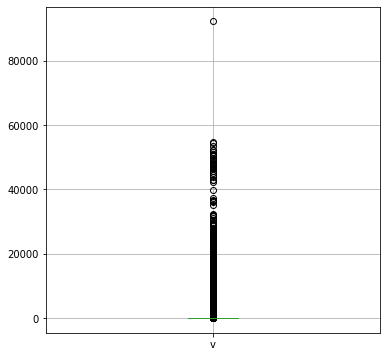

In [24]:
vbx = df['v'].plot.box(grid=True, figsize=(6,6))

In [ ]:
cleaner = DataCleaner()

In [ ]:
def zero_runs(a):
    # Source: https://stackoverflow.com/questions/24885092/finding-the-consecutive-zeros-in-a-numpy-array
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

The `get_top_whisker_speed` function calculates the speed corresponding to the top whisker on a box-and-whiskers plot, using Tukey's formulation. The top whisker corresponds to 1.5 times the interquartile range added to the third quartile value. Use this function to calculate the most likely top speed on a per-vehicle basis, when fixing the type-2 anomalies.

In [ ]:
def get_top_whisker_speed(df):
    q = df['v'].quantile([.25, .5, .75])
    iqr = q.loc[0.75] - q.loc[0.25]
    return q.loc[0.75] + 1.5 * iqr

The `process_vehicle` function fixes all anomalies on a vehicle partition of the data. After fixing the anomalies, the function returns a dictionary containing the vehicle identifier, the cleaned-up DataFrame, the type 2 anomalies DataFrame, and the _top whisker speed_ value for the vehicle.

In [ ]:
def process_vehicle(v, df):
    df = cleaner.calculate_derived_columns(df)
    df = cleaner.fix_type1_anomalies(df)
    max_v = get_top_whisker_speed(df)
    df, anomalies = cleaner.fix_type2_anomalies(df, max_speed=max_v)
    return {'v': v, 'df': df, 'anom': anomalies, 'max_v': max_v }

Create an array with the input data for the parallel anomaly correction process. Each array element contains the required parameters for a call to the `process_vehicle` function. Having the data split up by vehicle helps in the parallelization process. Each process looks at a single partition of the data, avoiding data concurrency problems.

In [ ]:
vehicle_data = [{'v': v, 'df': df[df['VehicleID'] == v].copy().sort_values(by='Timestamp')} for v in tqdm(vehicles)]

We do not need the main DataFrame anymore, so we can do away with it and save some precious memory in the process.

In [ ]:
df = None

Now run the parallel process that fixes all the anomalies. Note that this piece of code can take a long time to run, depending on your hardware. The more cores, the better!

In [ ]:
fixed_data = parallel_process(vehicle_data, process_vehicle, use_kwargs=True, tqdm=tqdm)

Create the sub folders in the `data` folder to receive the fixed data and the anomaly data _per vehicle_.

In [ ]:
import os
if not os.path.exists("data/fixed"):
    os.makedirs("data/fixed")
    
if not os.path.exists("data/anomaly"):
    os.makedirs("data/anomaly")

Save both the fixed per-vehicle DataFrames and the anomaly points. These might still be of use in the future, who knows?

In [ ]:
for vd in tqdm(fixed_data):
    if isinstance(vd, dict):
        v = vd['v']
        df = vd['df']
        anom = vd['anom']
        df.to_parquet("data/fixed/v_{0}.parquet".format(v), index=False)
        
        if anom is not None:
            anom.to_parquet("data/anomaly/a_{0}.parquet".format(v), index=False)

Calculate the bounding box of the samples and save it on a JSON text file for later use.

In [ ]:
import sys
import json

min_lat = sys.float_info.max
max_lat = -sys.float_info.max
min_lon = sys.float_info.max
max_lon = -sys.float_info.max

for vd in tqdm(fixed_data):
    if isinstance(vd, dict):
        v = vd['v']
        df = vd['df']
        anom = vd['anom']       
        min_lat = min(min_lat, df['Lat'].min())
        max_lat = max(max_lat, df['Lat'].max())
        min_lon = min(min_lon, df['Lon'].min())
        max_lon = max(max_lon, df['Lon'].max())

bbox = {'west': min_lon, 'east': max_lon, 'north': max_lat, 'south': min_lat}

with open('data/bbox.txt', 'w') as json_file:
  json.dump(bbox, json_file)